<a href="https://colab.research.google.com/github/marshmelloyahya/TP1ComputerVision/blob/main/Copie_de_Devoir1_Compte_Rendu_TP_Linear_Classifier_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2024-04-06 00:44:27--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  57.4MB/s    in 2.8s    

2024-04-06 00:44:30 (57.4 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [ ]:
! tar -xvf /content/cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


#Add torch tensor support

Ces cellules de code sont utilisées pour importer les bibliothèques nécessaires et installer les dépendances manquantes. Elles sont cruciales pour exécuter le reste du notebook.


In [ ]:
import torch

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

Cette section définit quelques fonctions d'utilité qui seront utilisées dans la suite du notebook. Ces fonctions incluent notamment le chargement des données, la normalisation, la conversion des étiquettes en vecteurs one-hot.

In [ ]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

Cette cellule charge les données MNIST, un ensemble de données standard utilisé pour la classification d'images.

In [ ]:
dict_batch_1 = unpickle("/content/cifar-10-batches-py/data_batch_1")
dict_batch_1.keys()
print(dict_batch_1[b'data'].dtype)
print(dict_batch_1[b'data'].shape)
print(len(dict_batch_1[b'labels']))


uint8
(10000, 3072)
10000


# Lecture de l'ensemble des labels du dataset

Charger les métadonnées à partir du fichier "batches.meta" dans le répertoire spécifié.
Décoder les noms des étiquettes en UTF-8 et les stocker dans une liste

In [ ]:
batches_meta = unpickle("/content/cifar-10-batches-py/batches.meta")
[label.decode('utf-8') for label in batches_meta[b'label_names']]

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# Acces au 'data' (images) des differents batches

Cette cellule affiche quelques exemples d'images MNIST pour que nous puissions avoir une idée visuelle de ce à quoi ressemblent les données.

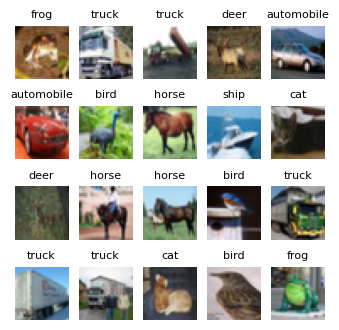

In [ ]:
# Définit une fonction nommée vect2image qui prend un vecteur en entrée et renvoie une image en couleurs.
def vect2image(vector):
  '''
   Conversion format vecteur => format image en couleurs
  '''
# Convertit le vecteur en un tenseur de taille (3, 32, 32), où 3 représente les canaux de couleur (rouge, vert et bleu) et 32x32 représente la taille de l'image.
  image = torch.tensor(vector).reshape((3, 32, 32) )
# Permute les dimensions du tenseur de façon à ce que les dimensions soient dans l'ordre (32, 32, 3), ce qui est le format attendu pour une image en couleurs.
  image = torch.permute( image, dims=(1, 2, 0))
  # image = np.transpose(image, axes=(1, 2, 0))
  return image

# afficher les 1eres 20 images dans le batch #1 du dataset, avec leurs labels respectifs
dict_batch_1 = unpickle("/content/cifar-10-batches-py/data_batch_1")

plt.figure( figsize=(4,4))
for i in range(20):
  image = vect2image(dict_batch_1[b'data'][i])
  plt.subplot(4, 5, i+1)
  plt.imshow(image);
  plt.title( batches_meta[b'label_names'][dict_batch_1[b'labels'][i]].decode('utf-8'), fontdict={'fontsize':8} )
  plt.axis('off')
plt.show()

# Charger tous les batches d'entrainement et former les train et valid datasets


In [ ]:
# Chargement des données d'entraînement à partir des fichiers data_batch_1 à data_batch_5
# La fonction unpickle est utilisée pour charger chaque fichier de lot de données
# Un fichier de lot de données contient un dictionnaire contenant les images, les étiquettes et d'autres métadonnées
# La compréhension de liste est utilisée pour itérer sur les nombres de 1 à 5 et charger les données de chaque fichier
all_dict_data_batches = [unpickle(f"/content/cifar-10-batches-py/data_batch_{num}") for num in range(1, 6)]

# Chargement des données de test à partir du fichier test_batch
# La fonction unpickle est utilisée pour charger le fichier de lot de données de test
# Le fichier de lot de données de test contient un dictionnaire contenant les images, les étiquettes et d'autres métadonnées
dict_test_batch = unpickle(f"/content/cifar-10-batches-py/test_batch")


In [ ]:
#  Cette ligne affiche la longueur de la liste all_dict_data_batches. La fonction len() retourne le nombre d'éléments dans la liste. Dans ce cas, cela nous donne le nombre total de batches de données contenus dans all_dict_data_batches.
print(len(all_dict_data_batches))
# Cette ligne affiche la forme (shape) des données contenues dans le premier batch de all_dict_data_batches. all_dict_data_batches[0] donne accès au premier élément de la liste
print(all_dict_data_batches[0][b'data'].shape)


5
(10000, 3072)


Ces lignes de code préparent les données d'entraînement et de test pour un modèle d'apprentissage automatique, en les chargeant à partir de différentes sources de données et en les transformant en tensors utilisables. Les données d'images sont concaténées à partir de plusieurs batches d'entraînement, et les étiquettes correspondantes sont également concaténées. De plus, les données d'images et les étiquettes de classe sont extraites des batchs de test et converties en tensors. Les formes (shapes) des tensors résultants sont ensuite imprimées pour vérification.

In [ ]:
train_images = torch.concat([ torch.tensor(all_dict_data_batches[j][b'data']) for j in range(5)], axis=0)
print(train_images.shape)

test_images = torch.tensor(dict_test_batch[b'data'])
print(test_images.shape)

train_labels = torch.concat([torch.tensor(all_dict_data_batches[j][b'labels']) for j in range(5)], axis=0)
print(train_labels.shape)

test_labels = torch.tensor(dict_test_batch[b'labels']) # convert list to np.array
print(test_labels.shape)
# (train1, val1), (train2, val2), ....

torch.Size([50000, 3072])
torch.Size([10000, 3072])
torch.Size([50000])
torch.Size([10000])


La fonction CE_loss est utilisée pour calculer la perte softmax ou l'entropie croisée entre les prédictions du modèle et les étiquettes réelles (ou vraies classes) des données

In [ ]:
def svm_loss(X, y, scores):
    '''
    Implémente la SVM ou Hinge Loss

    Args:
        X (torch.Tensor): Images (tenseurs)
        y (torch.Tensor): Labels (tenseurs)
        scores (torch.Tensor): Scores prédits par le modèle pour chaque classe (tenseurs)

    Returns:
        torch.Tensor: Tableau de pertes pour chaque image dans le batch
    '''

    # Nombre d'images dans le batch
    num_images = X.shape[0]

    # Nombre total de classes
    num_classes = 10

    # Initialisation du tableau de pertes avec des zéros
    losses = torch.zeros((num_images,))

    # Boucle sur chaque image dans le batch
    for i in range(num_images):
        # Calcul des marges de classification pour l'image actuelle
        margins = torch.maximum(torch.tensor(0), scores[i] - scores[i, y[i]] + 1)

        # Ignorer la marge pour la vraie classe (elle doit être zéro)
        margins[y[i]] = 0

        # Calcul de la perte SVM pour l'image actuelle en sommant les marges
        losses[i] = torch.sum(margins)

    return losses


def CE_loss(X, y, scores):
    '''
    Implemenete la softmax or Cross-entropy Loss

    X : Images (tensors)
    y : Labels (tensors)
    scores : Tensors
    '''
    num_images = X.shape[0]
    num_classes = 10
    losses = np.zeros((num_images,))

    for i in range(num_images):
        # Calcul des logits à l'aide de la fonction softmax
        exp_scores = np.exp(scores[i])
        probs = exp_scores / np.sum(exp_scores)

        # Sélection de la probabilité prédite pour la vraie classe
        predicted_prob = probs[y[i]]

        # Calcul de la perte d'entropie croisée
        losses[i] = -np.log(predicted_prob)

    return losses



In [ ]:

class LinearClassifier():
    def __init__(self) -> None:
        '''
        Initialise les poids et les biais du classifieur linéaire.

        Les poids (W) sont initialisés avec une distribution uniforme aléatoire.
        Les biais (b) sont également initialisés avec une distribution uniforme aléatoire.

        '''
        # Initialisation des poids (W) avec une distribution uniforme aléatoire
        # W est de taille (nombre de classes, taille des images)
        self.W = torch.rand((10, 3072), requires_grad=True)

        # Initialisation des biais (b) avec une distribution uniforme aléatoire
        # b est un vecteur de taille (nombre de classes,)
        self.b = torch.rand((10,), requires_grad=True)

    def predict(self, X):
        '''
        Prédit les scores pour chaque classe pour les images données.

        Args:
            X (torch.Tensor): Les images d'entrée (tenseurs)

        Returns:
            torch.Tensor: Les scores prédits pour chaque classe pour chaque image
        '''
        # Conversion des images en float32 (si ce n'est pas déjà le cas)
        X = X.to(torch.float32)

        # Nombre d'images dans le batch
        num_images = X.shape[0]

        # Nombre total de classes
        num_classes = 10

        # Initialisation d'un tenseur de scores avec des zéros
        scores = torch.zeros((num_images, num_classes))

        # Boucle sur chaque image dans le batch
        for i in range(num_images):
            # Calcul des scores pour chaque classe pour l'image actuelle
            scores[i] = self.W.matmul(X[i]) + self.b

        return scores


<ipython-input-8-0c8f9774f934>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(vector).reshape((3, 32, 32) )


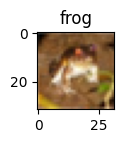

In [ ]:

# Nombre d'échantillons à utiliser pour l'affichage
N_samples = 1000

# Sélection des premiers N_samples images et étiquettes du jeu de données d'entraînement
X = train_images[:N_samples]
y = train_labels[:N_samples]

# Affichage d'une seule image
plt.figure(figsize=(1., 1.))

# Conversion du vecteur d'image en image pour l'affichage
plt.imshow(vect2image(X[0]))

# Titre de l'image basé sur l'étiquette
plt.title(batches_meta[b'label_names'][y[0]].decode('utf-8'))

# Affichage de l'image
plt.show()



#Apprentissage du classificateur

In [ ]:
# Création d'une instance de la classe LinearClassifier
linear1 = LinearClassifier()

# Définition des hyperparamètres
lr = 1e-4       # Taux d'apprentissage (Learning rate)
lambda1 = 1e-4  # Terme de régularisation L2 (L2 Weights decay)

In [ ]:
# train model over some epochs
# Entraînement du modèle sur plusieurs époques
batch_size = 32
for epoch in range(100):

    # Prédiction des scores pour les images d'entraînement
    scores = linear1.predict(X)

    # Calcul de la perte SVM ou Hinge Loss
    svm_losses = svm_loss(X, y, scores)
    svm_loss_mean = 1 / N_samples * torch.sum(svm_losses)

    # Ajout d'une régularisation L2 (déclin des poids)
    total_loss = svm_loss_mean + lambda1 * torch.sum(linear1.W**2)

    # Rétropropagation : Calcul des gradients
    total_loss.backward()

    # Optimisation : Descente de gradient stochastique (SGD) ou mini-batch GD
    for batch_start in range(0, N_samples, batch_size):
        # Sélection du mini-lot
        X_batch = X[batch_start:batch_start+batch_size]
        y_batch = y[batch_start:batch_start+batch_size]

        # Prédiction des scores pour le mini-lot
        scores_batch = linear1.predict(X_batch)

        # Calcul de la perte SVM ou Hinge Loss pour le mini-lot
        svm_losses_batch = svm_loss(X_batch, y_batch, scores_batch)
        svm_loss_mean_batch = 1 / batch_size * torch.sum(svm_losses_batch)

        # Ajout d'une régularisation L2 (déclin des poids)
        total_loss_batch = svm_loss_mean_batch + lambda1 * torch.sum(linear1.W**2)

        # Rétropropagation : Calcul des gradients pour le mini-lot
        total_loss_batch.backward()

        # Optimisation : Descente de gradient stochastique (SGD) ou mini-batch GD
        with torch.no_grad():
            # Mise à jour des poids et des biais pour le mini-lot
            linear1.W -= lr * linear1.W.grad
            linear1.b -= lr * linear1.b.grad

            # Réinitialisation des gradients à zéro
            linear1.W.grad.zero_()
            linear1.b.grad.zero_()

    # Affichage de la perte moyenne pour chaque époque
    print(f"Epoch: {epoch}, Loss: {int(svm_loss_mean)}")


Epoch: 0, Loss: 15437
Epoch: 1, Loss: 5012
Epoch: 2, Loss: 3891
Epoch: 3, Loss: 4118
Epoch: 4, Loss: 3313
Epoch: 5, Loss: 3288
Epoch: 6, Loss: 2936
Epoch: 7, Loss: 2735
Epoch: 8, Loss: 2052
Epoch: 9, Loss: 1923
Epoch: 10, Loss: 1904
Epoch: 11, Loss: 1930
Epoch: 12, Loss: 2061
Epoch: 13, Loss: 1887
Epoch: 14, Loss: 1501
Epoch: 15, Loss: 1897
Epoch: 16, Loss: 1385
Epoch: 17, Loss: 1598
Epoch: 18, Loss: 1590
Epoch: 19, Loss: 1434
Epoch: 20, Loss: 1185
Epoch: 21, Loss: 1525
Epoch: 22, Loss: 1174
Epoch: 23, Loss: 1101
Epoch: 24, Loss: 1031
Epoch: 25, Loss: 1249
Epoch: 26, Loss: 1048
Epoch: 27, Loss: 1103
Epoch: 28, Loss: 1064
Epoch: 29, Loss: 1169
Epoch: 30, Loss: 1149
Epoch: 31, Loss: 1083
Epoch: 32, Loss: 1012
Epoch: 33, Loss: 914
Epoch: 34, Loss: 971
Epoch: 35, Loss: 941
Epoch: 36, Loss: 851
Epoch: 37, Loss: 1140
Epoch: 38, Loss: 986
Epoch: 39, Loss: 917
Epoch: 40, Loss: 1279
Epoch: 41, Loss: 1001
Epoch: 42, Loss: 1063
Epoch: 43, Loss: 852
Epoch: 44, Loss: 1619
Epoch: 45, Loss: 850
Epoch

<ipython-input-8-0c8f9774f934>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(vector).reshape((3, 32, 32) )


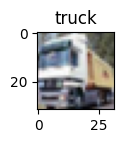

In [ ]:

# Création d'une nouvelle figure avec une taille de 1x1 pouce pour afficher une seule image
plt.figure(figsize=(1., 1.))

# Affichage de l'image convertie à partir du vecteur d'image (X[1])
plt.imshow(vect2image(X[1]))

# Ajout d'un titre à l'image basé sur l'étiquette correspondante (y[1])
# Les étiquettes sont décodées à partir des métadonnées des lots (batches_meta)
plt.title(batches_meta[b'label_names'][y[1]].decode('utf-8'))

# Affichage de l'image
plt.show()


In [ ]:
# Affichage des prédictions du modèle pour les 100 premières images
print("Predictions", torch.argmax(linear1.predict(X[:100]), dim=1))

# Affichage des étiquettes réelles pour les 100 premières images
print("Ground truth: ", y[:100])

Predictions tensor([6, 9, 9, 3, 1, 1, 2, 7, 8, 3, 2, 7, 7, 2, 9, 9, 9, 5, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 7, 4, 1, 5, 9, 1, 5, 4, 7, 3, 7, 8, 1, 5, 2, 4, 4, 1, 1, 1, 8,
        2, 0, 8, 5, 5, 5, 2, 2, 5, 4, 4, 8, 1, 1, 8, 2, 1, 5, 4, 9, 7, 4, 5, 4,
        6, 7, 4, 5, 8, 5, 3, 1, 4, 5, 4, 5, 4, 3, 4, 7, 9, 4, 3, 5, 8, 1, 1, 6,
        1, 1, 4, 1])
Ground truth:  tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2,
        2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9,
        6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6,
        1, 1, 4, 1])


In [ ]:
(torch.argmax( linear1.predict(X[:100]), dim=1) - y[:100])==0

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True, False,
        False,  True,  True, False,  True, False,  True,  True, False, False,
         True,  True, False, False,  True,  True,  True, False,  True,  True,
        False,  True, False, False,  True,  True,  True, False,  True, False,
         True,  True,  True,  True,  True, False,  True,  True,  True, False,
         True, False,  True,  True, False, False, False, False,  True,  True,
        False,  True,  True,  True, False, False,  True,  True,  True,  True,
        False, False,  True, False,  True,  True,  True,  True,  True,  True])

In [ ]:
# Affichage des prédictions du modèle pour les 100 premières images
print("Predictions", torch.argmax(linear1.predict(X[:100]), dim=1))

# Affichage des étiquettes réelles pour les 100 premières images
print("Ground truth: ", y[:100])

Predictions tensor([6, 9, 9, 3, 1, 1, 2, 7, 8, 3, 2, 7, 7, 2, 9, 9, 9, 5, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 7, 4, 1, 5, 9, 1, 5, 4, 7, 3, 7, 8, 1, 5, 2, 4, 4, 1, 1, 1, 8,
        2, 0, 8, 5, 5, 5, 2, 2, 5, 4, 4, 8, 1, 1, 8, 2, 1, 5, 4, 9, 7, 4, 5, 4,
        6, 7, 4, 5, 8, 5, 3, 1, 4, 5, 4, 5, 4, 3, 4, 7, 9, 4, 3, 5, 8, 1, 1, 6,
        1, 1, 4, 1])
Ground truth:  tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2,
        2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9,
        6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6,
        1, 1, 4, 1])


In [ ]:
# Accès aux noms des classes à partir de batches_meta
batches_meta[b'label_names']

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

<ipython-input-8-0c8f9774f934>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(vector).reshape((3, 32, 32) )


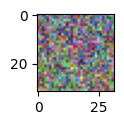

In [ ]:
# Transformation des poids de la classe 7 en une image
W = vect2image(linear1.W[7])

# Normalisation des valeurs des poids entre 0 et 1
W = (W - W.min()) / (W.max() - W.min())

# Création d'une nouvelle figure avec une taille de 1x1 pouce pour afficher les poids
plt.figure(figsize=(1., 1.))

# Affichage des poids normalisés
plt.imshow(W)